In [ ]:
from google.colab import drive
import os

# Google Colab Patch
use_colab = True
if use_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    # ----------------------------------------
    dir = "/content/drive/MyDrive/Cmput_328/assignment4"    # TODO: MODIFY THIS TO INDICATE THE PARENT FOLDER OF YOUR vit_model.py file
    # ----------------------------------------
    sys.path.append(dir)
from A4_utils import *

Mounted at /content/drive


load in dataset

In [ ]:
import torch
from torch.utils.data.dataset import Dataset  # For custom data-sets
from torchvision import transforms
import torchvision
from skimage.io import imread
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

CLASSES: [
    '__background__', '0'
    '1', '2', '3',
    '4', '5', '6',
    '7', '8', '9'
]

Num_classes: 11

data_path = '/content/drive/MyDrive/Cmput_328/assignment4/mnistdd_rgb_train_valid/'

# training
train_image_path = data_path + 'train_X.npy'
train_label_path = data_path + 'train_Y.npy'
train_bboxes_path = data_path + 'train_bboxes.npy'
train_seg_path = data_path + 'train_seg.npy'

# validation
valid_image_path= data_path + 'valid_X.npy'
valid_label_path= data_path +'valid_Y.npy'
valid_bboxes_path = data_path +'valid_bboxes.npy'
valid_seg_path = data_path +'valid_seg.npy'


class CustomDataset(Dataset):
    def __init__(self, image_paths, label_paths, bounding_box_path, masks_paths, train=True):   # initial logic happens like transform
        self.images = np.load(image_paths)
        self.label =  np.load(label_paths)
        self.mask = np.load(masks_paths)
        self.bboxes = np.load(bounding_box_path)
        self.transforms_image = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    def __getitem__(self, index):

         # Retrieve and preprocess a sample
        image = self.images[index].reshape(64, 64, 3)
        label = self.label[index]
        mask = self.mask[index].reshape(64, 64)

        bounding_boxes1 = self.bboxes[index][0]
        bounding_boxes2 = self.bboxes[index][1]

        boxes = torch.zeros([num_objs,4], dtype=torch.float32)
        bounding_boxes = [[bounding_boxes1[1], bounding_boxes1[0], bounding_boxes1[3], bounding_boxes1[2]],
            [bounding_boxes2[1], bounding_boxes2[0], bounding_boxes2[3], bounding_boxes2[2]]]
        # change it to xyxy format
        bounding_boxes = torch.as_tensor(bounding_boxes, dtype = torch.float32)
        # Apply any transformations if needed

        image = self.transforms_image(image)
        mask = torch.as_tensor(mask, dtype = torch.uint8)

        return image, {'boxes': bounding_boxes, 'labels': label, 'masks': mask}

    def __len__(self):  # return count of sample we have
        return len(self.images)

train_dataset = CustomDataset(train_image_path, train_label_path, train_bboxes_path, train_seg_path, train=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

valid_dataset = CustomDataset(valid_image_path, valid_label_path, valid_bboxes_path, valid_seg_path, train=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=True)

show some images

images shape torch.Size([1, 3, 64, 64])
labels shape torch.Size([1, 2])
bboxes shape torch.Size([1, 2, 4])
segmentation_masks shape torch.Size([1, 64, 64])


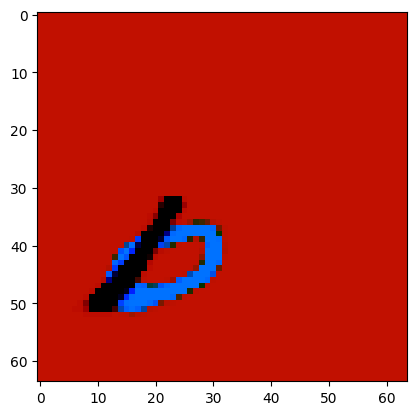

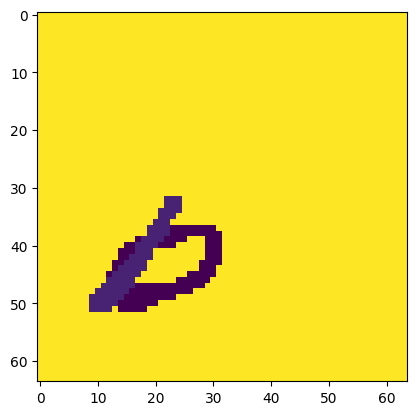

In [ ]:
import matplotlib.pyplot as plt

dataiter = enumerate(train_loader)
batch_idx, (images, target) = next(dataiter)

print(f"images shape {images.shape}")
print(f"labels shape {target['labels'].shape}")
print(f"bboxes shape {target['boxes'].shape}")
print(f"segmentation_masks shape {target['masks'].shape}")

plt.imshow(images[0].permute(1,2,0).data)
plt.show()
plt.imshow(target['masks'][0].data)
plt.show()

# plt.imshow(img_array, cmap='gray')
# plt.show()

define model

In [ ]:
# define the model

model = torchvision.models.detection.maskrcnn_resnet50_fpn()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , Num_classes)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , Num_classes)

# to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-3, weight_decay=1e-4)
# optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
# train the model
all_train_losses = []
all_val_losses = []
flag = False
for epoch in range(30):
    train_epoch_loss = 0
    val_epoch_loss = 0
    model.train()
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        print(targets)
        targets = [{k: v.to(device) for k, v in targets.items()}]
        loss = model(imgs , targets)
        if not flag:
            print(loss)
            flag = True
        losses = sum([l for l in loss.values()])
        train_epoch_loss += losses.cpu().detach().numpy()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    all_train_losses.append(train_epoch_loss)
    with torch.no_grad():
        for j , dt in enumerate(valid_loader):
            imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
            targ = [dt[0][1] , dt[1][1]]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
            loss = model(imgs , targets)
            losses = sum([l for l in loss.values()])
            val_epoch_loss += losses.cpu().detach().numpy()
        all_val_losses.append(val_epoch_loss)
    print(epoch , "  " , train_epoch_loss , "  " , val_epoch_loss)

{'boxes': tensor([[[22., 12., 50., 40.],
         [ 8., 17., 36., 45.]]]), 'labels': tensor([[4, 4]], dtype=torch.uint8), 'masks': tensor([[[10, 10, 10,  ..., 10, 10, 10],
         [10, 10, 10,  ..., 10, 10, 10],
         [10, 10, 10,  ..., 10, 10, 10],
         ...,
         [10, 10, 10,  ..., 10, 10, 10],
         [10, 10, 10,  ..., 10, 10, 10],
         [10, 10, 10,  ..., 10, 10, 10]]], dtype=torch.uint8)}


AssertionError: ignored

In [ ]:
def run_epoch(model, dataloader, optimizer, lr_scheduler, device, scaler, is_training):
    """
    Function to run a single training or evaluation epoch.

    Args:
        model: A PyTorch model to train or evaluate.
        dataloader: A PyTorch DataLoader providing the data.
        optimizer: The optimizer to use for training the model.
        loss_func: The loss function used for training.
        device: The device (CPU or GPU) to run the model on.
        scaler: Gradient scaler for mixed-precision training.
        is_training: Boolean flag indicating whether the model is in training or evaluation mode.

    Returns:
        The average loss for the epoch.
    """
    # Set the model to training mode
    model.train()

    epoch_loss = 0  # Initialize the total loss for this epoch
    progress_bar = tqdm(total=len(dataloader), desc="Train" if is_training else "Eval")  # Initialize a progress bar

    # Loop over the data
    for batch_id, (inputs, targets) in enumerate(dataloader):
        # Move inputs and targets to the specified device
        inputs = torch.stack(inputs).to(device)

        # Forward pass with Automatic Mixed Precision (AMP) context manager
        with autocast(torch.device(device).type):
            if is_training:
                losses = model(inputs.to(device), move_data_to_device(targets, device))
            else:
                with torch.no_grad():
                    losses = model(inputs.to(device), move_data_to_device(targets, device))

            # Compute the loss
            loss = sum([loss for loss in losses.values()])  # Sum up the losses

        # If in training mode, backpropagate the error and update the weights
        if is_training:
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                old_scaler = scaler.get_scale()
                scaler.update()
                new_scaler = scaler.get_scale()
                if new_scaler >= old_scaler:
                    lr_scheduler.step()
            else:
                loss.backward()
                optimizer.step()
                lr_scheduler.step()

            optimizer.zero_grad()

        # Update the total loss
        loss_item = loss.item()
        epoch_loss += loss_item

        # Update the progress bar
        progress_bar_dict = dict(loss=loss_item, avg_loss=epoch_loss/(batch_id+1))
        if is_training:
            progress_bar_dict.update(lr=lr_scheduler.get_last_lr()[0])
        progress_bar.set_postfix(progress_bar_dict)
        progress_bar.update()

        # If the loss is NaN or infinite, stop the training/evaluation process
        if math.isnan(loss_item) or math.isinf(loss_item):
            print(f"Loss is NaN or infinite at batch {batch_id}. Stopping {'training' if is_training else 'evaluation'}.")
            break

    # Cleanup and close the progress bar
    progress_bar.close()

    # Return the average loss for this epoch
    return epoch_loss / (batch_id + 1)

def train_loop(model,
               train_dataloader,
               valid_dataloader,
               optimizer,
               lr_scheduler,
               device,
               epochs,
               checkpoint_path,
               use_scaler=False):
    """
    Main training loop.

    Args:
        model: A PyTorch model to train.
        train_dataloader: A PyTorch DataLoader providing the training data.
        valid_dataloader: A PyTorch DataLoader providing the validation data.
        optimizer: The optimizer to use for training the model.
        lr_scheduler: The learning rate scheduler.
        device: The device (CPU or GPU) to run the model on.
        epochs: The number of epochs to train for.
        checkpoint_path: The path where to save the best model checkpoint.
        use_scaler: Whether to scale graidents when using a CUDA device

    Returns:
        None
    """
    # Initialize a gradient scaler for mixed-precision training if the device is a CUDA GPU
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' and use_scaler else None
    best_loss = float('inf')  # Initialize the best validation loss

    # Loop over the epochs
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # Run a training epoch and get the training loss
        train_loss = run_epoch(model, train_dataloader, optimizer, lr_scheduler, device, scaler, is_training=True)
        # Run an evaluation epoch and get the validation loss
        with torch.no_grad():
            valid_loss = run_epoch(model, valid_dataloader, None, None, device, scaler, is_training=False)

        # If the validation loss is lower than the best validation loss seen so far, save the model checkpoint
        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

            # Save metadata about the training process
            training_metadata = {
                'epoch': epoch,
                'train_loss': train_loss,
                'valid_loss': valid_loss,
                'learning_rate': lr_scheduler.get_last_lr()[0],
                'model_architecture': model.name
            }
            with open(Path(checkpoint_path.parent/'training_metadata.json'), 'w') as f:
                json.dump(training_metadata, f)

        # If the training or validation loss is NaN or infinite, stop the training process
        if any(math.isnan(loss) or math.isinf(loss) for loss in [train_loss, valid_loss]):
            print(f"Loss is NaN or infinite at epoch {epoch}. Stopping training.")
            break

    # If the device is a GPU, empty the cache
    if device.type != 'cpu':
        getattr(torch, device.type).empty_cache()

# Learning rate for the model
lr = 5e-4

# Number of training epochs
epochs = 40

# AdamW optimizer; includes weight decay for regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# Learning rate scheduler; adjusts the learning rate during training
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                   max_lr=lr,
                                                   total_steps=epochs*len(train_dataloader))
train_loop(model=model,
           train_dataloader=train_dataloader,
           valid_dataloader=valid_dataloader,
           optimizer=optimizer,
           lr_scheduler=lr_scheduler,
           device=torch.device(device),
           epochs=epochs,
           checkpoint_path=checkpoint_path,
           use_scaler=True)

helper functions for training

In [ ]:
def compute_classification_acc(pred, gt):
    assert pred.shape == gt.shape
    return (pred == gt).astype(int).sum() / gt.size


def compute_segmentation_acc(pred, gt):
    # pred value should be from 0 to 10, where 10 is the background.
    assert pred.shape == gt.shape

    return (pred == gt).astype(int).sum() / gt.size


def get_iou(bbox_pred, bbox_gt, L_pred, L_gt):
    """all pixel coordinates within the prediction bounding box"""
    rr, cc = polygon([bbox_pred[0], bbox_pred[0], bbox_pred[2], bbox_pred[2]],
                     [bbox_pred[1], bbox_pred[3], bbox_pred[3], bbox_pred[1]], [64, 64])
    L_pred[rr, cc] = 1

    """all pixel coordinates within the GT bounding box"""
    rr, cc = polygon([bbox_gt[0], bbox_gt[0], bbox_gt[2], bbox_gt[2]],
                     [bbox_gt[1], bbox_gt[3], bbox_gt[3], bbox_gt[1]], [64, 64])
    L_gt[rr, cc] = 1

    L_sum = L_pred + L_gt
    intersection = np.sum(L_sum == 2)
    union = np.sum(L_sum >= 1)

    iou = intersection / union

    L_pred[:, :] = 0
    L_gt[:, :] = 0

    return iou


def compute_mean_iou(bboxes_pred, bboxes_gt, classes_pred, classes_gt):
    """

    :param bboxes_pred: predicted bounding boxes, shape=(n_images,2,4)
    :param bboxes_gt: ground truth bounding boxes, shape=(n_images,2,4)
    :param classes_pred: predicted classes, shape=(n_images,2)
    :param classes_gt: ground truth classes, shape=(n_images,2)
    :return:
    """

    n_images = np.shape(bboxes_gt)[0]
    L_pred = np.zeros((64, 64))
    L_gt = np.zeros((64, 64))
    iou_sum = 0.0
    for i in range(n_images):
        iou1 = get_iou(bboxes_pred[i, 0, :], bboxes_gt[i, 0, :], L_pred, L_gt)
        iou2 = get_iou(bboxes_pred[i, 1, :], bboxes_gt[i, 1, :], L_pred, L_gt)

        iou_sum1 = iou1 + iou2

        if classes_pred[i, 0] == classes_pred[i, 1] and classes_gt[i, 0] == classes_gt[i, 1]:
            iou1 = get_iou(bboxes_pred[i, 0, :], bboxes_gt[i, 1, :], L_pred, L_gt)
            iou2 = get_iou(bboxes_pred[i, 1, :], bboxes_gt[i, 0, :], L_pred, L_gt)

            iou_sum2 = iou1 + iou2

            if iou_sum2 > iou_sum1:
                iou_sum1 = iou_sum2

        iou_sum += iou_sum1

    mean_iou = iou_sum / (2. * n_images)

    return mean_iou

A4_submission.py

In [ ]:
import numpy as np

# add the model and the training and validation code
# will train the model and save the model
# only no need to submmit running the training of the model

def detect_and_segment(images):
    """

    :param np.ndarray images: N x 12288 array containing N 64x64x3 images flattened into vectors
    :return: np.ndarray, np.ndarray
    """
    N = images.shape[0]





    # pred_class: Your predicted labels for the 2 digits, shape [N, 2]
    pred_class = np.empty((N, 2), dtype=np.int32)
    # pred_bboxes: Your predicted bboxes for 2 digits, shape [N, 2, 4]
    pred_bboxes = np.empty((N, 2, 4), dtype=np.float64)
    # pred_seg: Your predicted segmentation for the image, shape [N, 4096]
    pred_seg = np.empty((N, 4096), dtype=np.int32)
    # add your code here to fill in pred_class and pred_bboxes

    return pred_class, pred_bboxes, pred_seg

A4_main.py

In [ ]:
import os.path
import timeit
import numpy as np
from skimage.draw import polygon

from A4_submission import detect_and_segment


def compute_classification_acc(pred, gt):
    assert pred.shape == gt.shape
    return (pred == gt).astype(int).sum() / gt.size


def compute_segmentation_acc(pred, gt):
    # pred value should be from 0 to 10, where 10 is the background.
    assert pred.shape == gt.shape

    return (pred == gt).astype(int).sum() / gt.size


def get_iou(bbox_pred, bbox_gt, L_pred, L_gt):
    """all pixel coordinates within the prediction bounding box"""
    rr, cc = polygon([bbox_pred[0], bbox_pred[0], bbox_pred[2], bbox_pred[2]],
                     [bbox_pred[1], bbox_pred[3], bbox_pred[3], bbox_pred[1]], [64, 64])
    L_pred[rr, cc] = 1

    """all pixel coordinates within the GT bounding box"""
    rr, cc = polygon([bbox_gt[0], bbox_gt[0], bbox_gt[2], bbox_gt[2]],
                     [bbox_gt[1], bbox_gt[3], bbox_gt[3], bbox_gt[1]], [64, 64])
    L_gt[rr, cc] = 1

    L_sum = L_pred + L_gt
    intersection = np.sum(L_sum == 2)
    union = np.sum(L_sum >= 1)

    iou = intersection / union

    L_pred[:, :] = 0
    L_gt[:, :] = 0

    return iou


def compute_mean_iou(bboxes_pred, bboxes_gt, classes_pred, classes_gt):
    """

    :param bboxes_pred: predicted bounding boxes, shape=(n_images,2,4)
    :param bboxes_gt: ground truth bounding boxes, shape=(n_images,2,4)
    :param classes_pred: predicted classes, shape=(n_images,2)
    :param classes_gt: ground truth classes, shape=(n_images,2)
    :return:
    """

    n_images = np.shape(bboxes_gt)[0]
    L_pred = np.zeros((64, 64))
    L_gt = np.zeros((64, 64))
    iou_sum = 0.0
    for i in range(n_images):
        iou1 = get_iou(bboxes_pred[i, 0, :], bboxes_gt[i, 0, :], L_pred, L_gt)
        iou2 = get_iou(bboxes_pred[i, 1, :], bboxes_gt[i, 1, :], L_pred, L_gt)

        iou_sum1 = iou1 + iou2

        if classes_pred[i, 0] == classes_pred[i, 1] and classes_gt[i, 0] == classes_gt[i, 1]:
            iou1 = get_iou(bboxes_pred[i, 0, :], bboxes_gt[i, 1, :], L_pred, L_gt)
            iou2 = get_iou(bboxes_pred[i, 1, :], bboxes_gt[i, 0, :], L_pred, L_gt)

            iou_sum2 = iou1 + iou2

            if iou_sum2 > iou_sum1:
                iou_sum1 = iou_sum2

        iou_sum += iou_sum1

    mean_iou = iou_sum / (2. * n_images)

    return mean_iou


class Params:
    def __init__(self):
        # self.prefix = "test"
        self.prefix = "valid"
        # self.prefix = "train"
        self.load = 1
        self.save = 1
        self.load_path = 'saved_preds.npz'
        self.vis = 0
        self.vis_size = (300, 300)
        self.show_det = 0
        self.show_seg = 1

        self.speed_thresh = 10
        self.acc_thresh = (0.7, 0.98)
        self.iou_thresh = (0.7, 0.98)
        self.seg_thresh = (0.7, 0.98)

        self.class_cols = {
            0: 'red',
            1: 'green',
            2: 'blue',
            3: 'magenta',
            4: 'cyan',
            5: 'yellow',
            6: 'purple',
            7: 'forest_green',
            8: 'orange',
            9: 'white',
            10: 'black',
        }


def compute_score(res, thresh):
    min_thres, max_thres = thresh

    if res < min_thres:
        score = 0.0
    elif res > max_thres:
        score = 100.0
    else:
        score = float(res - min_thres) / (max_thres - min_thres) * 100
    return score


def main():
    params = Params()

    try:
        import paramparse
    except ImportError:
        pass
    else:
        paramparse.process(params)

    prefix = params.prefix

    images = np.load(prefix + "_X.npy")
    gt_classes = np.load(prefix + "_Y.npy")
    gt_bboxes = np.load(prefix + "_bboxes.npy")
    gt_seg = np.load(prefix + "_seg.npy")

    n_images = images.shape[0]

    if params.load and os.path.exists(params.load_path):
        print(f'loading predictions from {params.load_path}')
        saved_preds = np.load(params.load_path)
        pred_classes = saved_preds['pred_classes']
        pred_bboxes = saved_preds['pred_bboxes']
        pred_seg = saved_preds['pred_seg']

        test_time = test_speed = 0
    else:
        print(f'running prediction on {n_images} {prefix} images')
        start_t = timeit.default_timer()
        pred_classes, pred_bboxes, pred_seg = detect_and_segment(images)
        end_t = timeit.default_timer()
        test_time = end_t - start_t
        assert test_time > 0, "test_time cannot be 0"
        test_speed = float(n_images) / test_time

        if params.save:
            np.savez_compressed(params.load_path, pred_classes=pred_classes, pred_bboxes=pred_bboxes, pred_seg=pred_seg)

    cls_acc = compute_classification_acc(pred_classes, gt_classes)
    iou = compute_mean_iou(pred_bboxes, gt_bboxes, pred_classes, gt_classes)
    seg_acc = compute_segmentation_acc(pred_seg, gt_seg)

    acc_score = compute_score(cls_acc, params.acc_thresh)
    iou_score = compute_score(iou, params.iou_thresh)
    seg_score = compute_score(seg_acc, params.seg_thresh)

    if test_speed < params.speed_thresh:
        overall_score = 0
    else:
        overall_score = ((iou_score + acc_score) / 2. + seg_score) / 2.

    print(f"Classification Accuracy: {cls_acc*100:.3f} %")
    print(f"Detection IOU: {iou*100:.3f} %")
    print(f"Segmentation Accuracy: {seg_acc*100:.3f} %")

    print(f"Test time: {test_time:.3f} seconds")
    print(f"Test speed: {test_speed:.3f} images / second")

    print(f"Classification Score: {acc_score:.3f}")
    print(f"IOU Score: {iou_score:.3f}")
    print(f"Segmentation Score: {seg_score:.3f}")
    print(f"Overall Score: {overall_score:.3f}")

    if not params.vis:
        return

    import cv2
    from A4_utils import vis_bboxes, vis_seg, annotate

    print('press spacebar to toggle pause and escape to quit')
    pause_after_frame = 1
    for img_id in range(n_images):
        src_img = images[img_id, ...].squeeze()
        src_img = src_img.reshape((64, 64, 3)).astype(np.uint8)

        vis_img = np.copy(src_img)

        bbox_1 = gt_bboxes[img_id, 0, :].squeeze().astype(np.int32)
        bbox_2 = gt_bboxes[img_id, 1, :].squeeze().astype(np.int32)
        y1, y2 = gt_classes[img_id, ...].squeeze()
        gt_classes[img_id, ...].squeeze()
        vis_img = vis_bboxes(vis_img, bbox_1, bbox_2, y1, y2, params.vis_size)
        vis_img_seg_gt = vis_seg(src_img, gt_seg, img_id, params.class_cols, params.vis_size)

        vis_img_list = [vis_img, vis_img_seg_gt]
        vis_img_labels = ['gt det', 'gt seg']

        if params.show_det:
            vis_img_det = np.copy(src_img)
            bbox_1 = pred_bboxes[img_id, 0, :].squeeze().astype(np.int32)
            bbox_2 = pred_bboxes[img_id, 1, :].squeeze().astype(np.int32)
            y1, y2 = pred_classes[img_id, ...].squeeze()
            gt_classes[img_id, ...].squeeze()
            vis_img_det = vis_bboxes(vis_img_det, bbox_1, bbox_2, y1, y2, params.vis_size)
            vis_img_list.append(vis_img_det)
            vis_img_labels.append('pred det')

        if params.show_seg:
            vis_img_seg = vis_seg(src_img, pred_seg, img_id, params.class_cols, params.vis_size)
            vis_img_list.append(vis_img_seg)
            vis_img_labels.append('pred seg')

        vis_img = annotate(vis_img_list,
                           text=f'image {img_id}',
                           img_labels=vis_img_labels, grid_size=(1, -1))
        cv2.imshow('vis_img', vis_img)

        key = cv2.waitKey(1 - pause_after_frame)
        if key == 27:
            return
        elif key == 32:
            pause_after_frame = 1 - pause_after_frame


if __name__ == '__main__':
    main()